# MathScore Prediction model

This notebook trains an XGBoost regression model to predict MathScore and includes:
- **Data Preprocessing**: Loading and preparing training/test data
- **Model Training**: XGBoost with optimized hyperparameters
- **Visualization**: Prediction analysis and residual plots
- **SHAP Analysis**: Feature importance and model interpretability
- **Predictions**: Generate and export final predictions

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from xgboost import XGBRegressor
import shap

# Set visualization style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# Columns to drop (100% null in X_test or irrelevant identifiers)
COLS_TO_DROP = [
    # Science and reading columns with 100% null values in X_test
    'science_q18_total_timing', 'science_q16_average_score', 'science_q19_average_score',
    'science_q18_average_score', 'science_q19_total_timing', 'science_q17_total_timing',
    'science_q16_total_timing', 'science_q14_average_score', 'science_q15_average_score',
    'reading_q15_average_score', 'science_q15_total_timing', 'science_q14_total_timing',
    'science_q17_average_score', 'science_q13_average_score', 'science_q13_total_timing',
    'reading_q15_total_timing', 'reading_q14_average_score', 'reading_q14_total_timing',
    'reading_q13_average_score', 'reading_q13_total_timing', 'reading_q12_average_score',
    'reading_q11_average_score', 'reading_q12_total_timing', 'reading_q11_total_timing',
    # Identifier and metadata columns
    "Year", "CNTRYID", "CNTSCHID", "CNTSTUID", "CYC", "NatCen", "STRATUM", "SUBNATIO",
    "OECD", "ADMINMODE", "LANGTEST_QQQ", "LANGTEST_COG", "LANGTEST_PAQ", "Option_CT",
    "Option_FL", "Option_ICTQ", "Option_WBQ", "Option_PQ", "Option_TQ", "Option_UH",
    "BOOKID", "COBN_S", "PA167", "WB153", "WB154", "WB155", "WB160", "WB162", "WB168",
    "WB177", "WB178", "ST038", "ST036", "IC170", "IC173", "IC176", "IC177", "IC175",
    "IC183", "IC182", "IC180", "ST003D03T", "PA008", "PA003", "ST006", "PA159", "ST150"
]


def preprocess_data(df, is_training=True):
    """Preprocess dataframe by dropping irrelevant columns and converting types."""
    id_col = df['Unnamed: 0'].copy() if 'Unnamed: 0' in df.columns else None

    if 'Unnamed: 0' in df.columns:
        df = df.drop(columns=['Unnamed: 0'])

    cols_to_drop = [col for col in COLS_TO_DROP if col in df.columns]
    df = df.drop(columns=cols_to_drop)

    # Drop math columns (except math_q1_total_timing which has data in test set)
    math_cols = [col for col in df.columns if col.startswith("math_q") and col != "math_q1_total_timing"]
    df = df.drop(columns=math_cols)

    # Convert object columns to categories for XGBoost
    for col in df.select_dtypes(include="object").columns:
        df[col] = df[col].astype("category")

    if is_training:
        print(f"Preprocessed training data: {df.shape}")
        return df
    else:
        print(f"Preprocessed test data: {df.shape}")
        return df, id_col


def create_interaction_features(df):
    """Create interaction terms between science and reading score/timing features."""
    new_features = {}

    score_cols = [c for c in df.columns if 'average_score' in c and not c.startswith('math')]
    timing_cols = [c for c in df.columns if 'total_timing' in c and not c.startswith('math')]

    science_score_cols = [c for c in score_cols if c.startswith('science')]
    reading_score_cols = [c for c in score_cols if c.startswith('reading')]
    science_timing_cols = [c for c in timing_cols if c.startswith('science')]
    reading_timing_cols = [c for c in timing_cols if c.startswith('reading')]

    # Cross-subject score interactions
    for sci_col in science_score_cols:
        q_num = sci_col.split('_')[1]
        read_col = f"reading_{q_num}_average_score"
        if read_col in df.columns:
            new_features[f'Science_Reading_{q_num}_Score'] = df[sci_col] * df[read_col]

    # Cross-subject timing interactions
    for sci_col in science_timing_cols:
        q_num = sci_col.split('_')[1]
        read_col = f"reading_{q_num}_total_timing"
        if read_col in df.columns:
            new_features[f'Science_Reading_{q_num}_Timing'] = df[sci_col] * df[read_col]

    # Score-to-timing ratios (efficiency metrics)
    for subj in ['science', 'reading']:
        subj_score = [c for c in score_cols if c.startswith(subj)]
        for score_col in subj_score:
            q_num = score_col.split('_')[1]
            timing_col = f"{subj}_{q_num}_total_timing"
            if timing_col in df.columns:
                new_features[f'{subj}_{q_num}_Efficiency'] = df[score_col] / (df[timing_col] + 1)

    # Aggregate scores per subject
    if science_score_cols:
        new_features['Science_Total_Score'] = df[science_score_cols].sum(axis=1)
        new_features['Science_Mean_Score'] = df[science_score_cols].mean(axis=1)
    if reading_score_cols:
        new_features['Reading_Total_Score'] = df[reading_score_cols].sum(axis=1)
        new_features['Reading_Mean_Score'] = df[reading_score_cols].mean(axis=1)

    # Aggregate timing
    if science_timing_cols:
        new_features['Science_Total_Timing'] = df[science_timing_cols].sum(axis=1)
    if reading_timing_cols:
        new_features['Reading_Total_Timing'] = df[reading_timing_cols].sum(axis=1)

    # Combined score
    if science_score_cols and reading_score_cols:
        new_features['Combined_Score'] = (df[science_score_cols].mean(axis=1) + df[reading_score_cols].mean(axis=1)) / 2

    # Score variance
    if science_score_cols:
        new_features['Science_Score_Std'] = df[science_score_cols].std(axis=1)
    if reading_score_cols:
        new_features['Reading_Score_Std'] = df[reading_score_cols].std(axis=1)

    # Overall score stats
    all_score_cols = science_score_cols + reading_score_cols
    if all_score_cols:
        new_features['Overall_Mean_Score'] = df[all_score_cols].mean(axis=1)
        new_features['Overall_Max_Score'] = df[all_score_cols].max(axis=1)
        new_features['Overall_Min_Score'] = df[all_score_cols].min(axis=1)
        new_features['Score_Range'] = new_features['Overall_Max_Score'] - new_features['Overall_Min_Score']

    # Timing patterns
    all_timing_cols = science_timing_cols + reading_timing_cols
    if all_timing_cols:
        new_features['Overall_Mean_Timing'] = df[all_timing_cols].mean(axis=1)
        new_features['Timing_Std'] = df[all_timing_cols].std(axis=1)

    # Efficiency ratios
    if science_score_cols and science_timing_cols:
        new_features['Science_Efficiency_Ratio'] = df[science_score_cols].mean(axis=1) / (df[science_timing_cols].mean(axis=1) + 1)
    if reading_score_cols and reading_timing_cols:
        new_features['Reading_Efficiency_Ratio'] = df[reading_score_cols].mean(axis=1) / (df[reading_timing_cols].mean(axis=1) + 1)

    # Score counts
    if all_score_cols:
        score_df = df[all_score_cols]
        new_features['High_Score_Count'] = (score_df >= 0.7).sum(axis=1)
        new_features['Low_Score_Count'] = (score_df <= 0.3).sum(axis=1)
        new_features['Perfect_Score_Count'] = (score_df == 1.0).sum(axis=1)
        new_features['Score_Answered_Count'] = score_df.notna().sum(axis=1)

    if all_timing_cols:
        new_features['Timing_Valid_Count'] = df[all_timing_cols].notna().sum(axis=1)

    # Science vs Reading comparison
    if science_score_cols and reading_score_cols:
        new_features['Science_vs_Reading_Score'] = df[science_score_cols].mean(axis=1) - df[reading_score_cols].mean(axis=1)

    for name, values in new_features.items():
        df[name] = values

    return df, list(new_features.keys())

In [ ]:
# Load and preprocess training data
df = pd.read_csv('/content/drive/MyDrive/HiParis/X_train.csv')
y_train_full = pd.read_csv('/content/drive/MyDrive/HiParis/y_train.csv')
print(f"Raw X_train: {df.shape}, y_train: {y_train_full.shape}")

# Keep Year separately for year-wise experiments (preprocess_data will drop it)
train_year = df['Year'].copy()

# Preprocess features (drops Year, IDs, math items, etc.)
X = preprocess_data(df, is_training=True)

# Use MathScore as a 1D Series target
y = y_train_full['MathScore'].astype(float)


## 1. Exploratory Data Analysis (EDA)

Before training models, we first explore the raw PISA data to understand:

- How the **target `MathScore`** behaves globally and across PISA cycles (2015, 2018, 2022),
- Whether there is **distribution shift** between years,
- The extent of **zero-inflation** in MathScore,
- **Missingness patterns** and almost-empty / constant features,
- Potential **leakage features**, e.g. highly correlated item-level scores,
- The **country / year** composition of the dataset.

This section focuses on diagnosis and problem framing, not optimization.


In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# Combine X and y for EDA
eda_df = df.merge(y_train_full, on='Unnamed: 0', how='inner')

print("Combined EDA dataframe shape:", eda_df.shape)
print("\nColumns:")
print(eda_df.columns.tolist()[:30], "...")

print("\nBasic info:")
print(eda_df[['Year', 'CNT', 'MathScore']].head())


Combined EDA dataframe shape: (1172086, 308)

Columns:
['Unnamed: 0', 'Year', 'CNT', 'CNTRYID', 'CNTSCHID', 'CNTSTUID', 'CYC', 'NatCen', 'STRATUM', 'SUBNATIO', 'OECD', 'ADMINMODE', 'LANGTEST_QQQ', 'LANGTEST_COG', 'LANGTEST_PAQ', 'Option_CT', 'Option_FL', 'Option_ICTQ', 'Option_WBQ', 'Option_PQ', 'Option_TQ', 'Option_UH', 'ST001D01T', 'ST003D02T', 'ST003D03T', 'ST004D01T', 'EFFORT1', 'EFFORT2', 'OCOD1', 'OCOD2'] ...

Basic info:
   Year  CNT   MathScore
0  2022  NLD  116.975422
1  2018  QAZ   73.387560
2  2018  FRA    0.000000
3  2015  QES    0.000000
4  2018  PHL  113.750718


### 1.1 Target `MathScore` distribution (global and per year)

We first inspect the overall distribution of `MathScore`, then how it changes across PISA cycles (`Year`).
This helps reveal:

- Skewness or heavy tails,
- Possible truncation at 0,
- Differences in scale between 2015, 2018 and 2022.


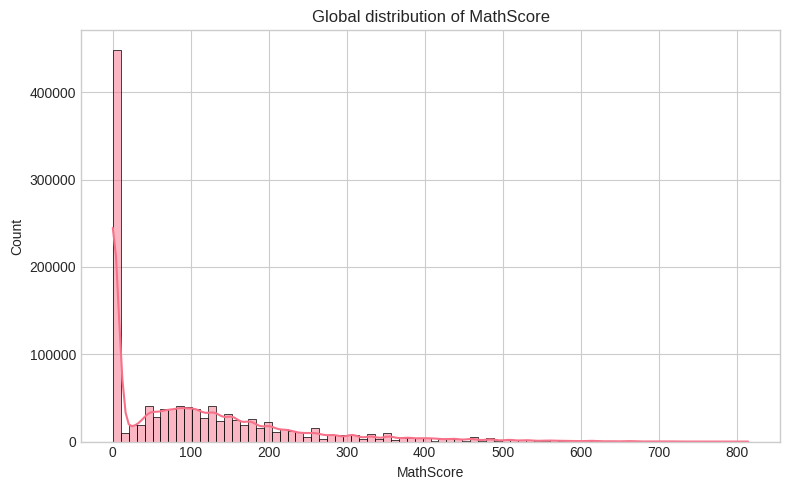

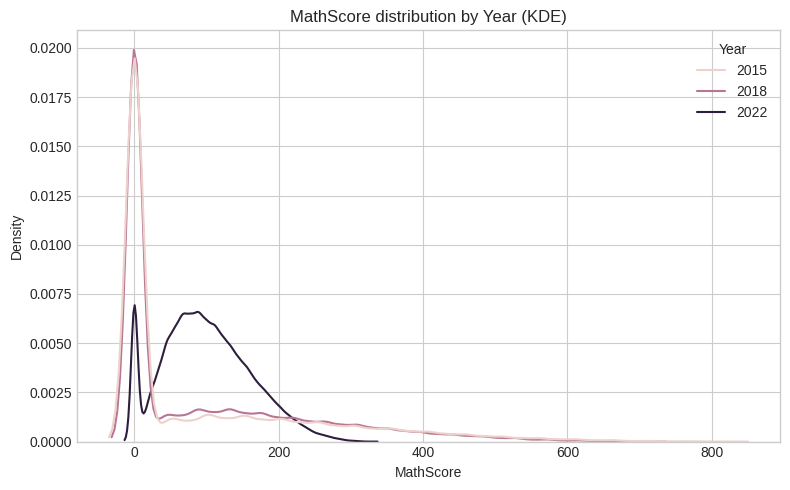

Summary statistics of MathScore by Year:


,count,mean,std,min,25%,50%,75%,max
Year,,,,,,,,
2015,348119.0,100.051846,150.952376,0.0,0.000000,0.00000,178.275225,814.972459
2018,411320.0,100.031883,139.751400,0.0,0.000000,0.00000,176.130143,704.520571
2022,412647.0,99.910654,60.891978,0.0,55.702582,94.69439,140.184832,323.074976


In [30]:
# Global histogram + KDE of MathScore
plt.figure(figsize=(8, 5))
sns.histplot(eda_df['MathScore'], bins=80, kde=True, edgecolor='black')
plt.title("Global distribution of MathScore")
plt.xlabel("MathScore")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Year-wise KDEs on the same axis
plt.figure(figsize=(8, 5))
sns.kdeplot(data=eda_df, x="MathScore", hue="Year", common_norm=False)
plt.title("MathScore distribution by Year (KDE)")
plt.xlabel("MathScore")
plt.ylabel("Density")
plt.tight_layout()
plt.show()

# Year-wise summary stats
year_stats_target = eda_df.groupby("Year")["MathScore"].describe()
print("Summary statistics of MathScore by Year:")
display(year_stats_target)


### 1.2 Zero-inflation and distribution shift across PISA cycles

From the plots above we can already see that:

- Some years have a **large spike at 0**, suggesting many students with `MathScore = 0`,
- The range and shape of scores appear different between 2015/2018 and 2022.

To quantify this, we compute the **proportion of zero scores per year**.


Zero inflation and basic stats by Year:


,n,n_zero,prop_zero,mean,std
Year,,,,,
2015,348119,199130,0.572017,100.051846,150.952376
2018,411320,215527,0.523989,100.031883,139.751400
2022,412647,32121,0.077841,99.910654,60.891978


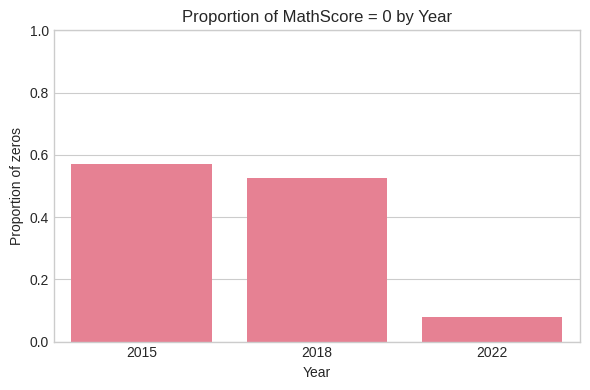

In [31]:
def zero_share(s):
    return (s == 0).mean()

zero_stats = (
    eda_df
    .groupby("Year")["MathScore"]
    .agg(
        n="size",
        n_zero=lambda s: (s == 0).sum(),
        prop_zero=zero_share,
        mean="mean",
        std="std"
    )
)

print("Zero inflation and basic stats by Year:")
display(zero_stats)

# Barplot of zero proportion by year
plt.figure(figsize=(6, 4))
sns.barplot(
    x=zero_stats.index.astype(int),
    y=zero_stats["prop_zero"].values
)
plt.title("Proportion of MathScore = 0 by Year")
plt.xlabel("Year")
plt.ylabel("Proportion of zeros")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


### 1.3 Country / year composition and sample balance

PISA is multi-country and multi-cycle. Before modeling, we want to know:

- How many **countries** are present,
- Which countries dominate the sample,
- How students are distributed across **Year × Country**.

Imbalanced countries/years can affect both training and interpretation.


Number of countries (CNT): 98

Top 10 countries by number of students:


,count
CNT,
ESP,48846
CAN,43899
ARE,38672
BRA,29880
AUS,28243
GBR,27436
KAZ,26296
QAT,22645
ITA,22588



Year × Country counts (showing first 10 countries):


CNT,ALB,ARE,ARG,AUS,AUT,BEL,BGR,BIH,BLR,BRA
Year,,,,,,,,,,
2015,3547,9372,0,9673,4658,6434,4069,0,0,15464
2018,4307,12885,7989,9622,4568,5651,3549,4335,3872,7156
2022,4157,16415,8088,8948,4149,5510,4134,0,0,7260


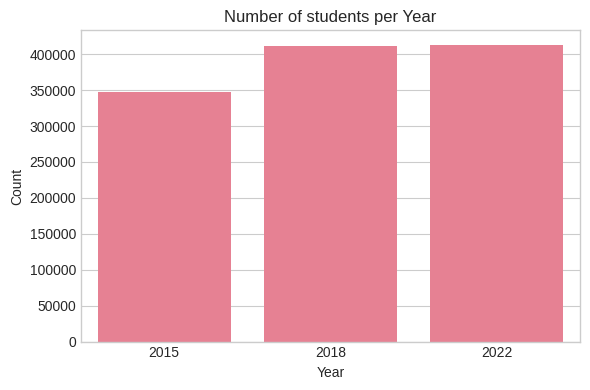

In [32]:
# Number of countries
n_countries = eda_df["CNT"].nunique()
print(f"Number of countries (CNT): {n_countries}")

print("\nTop 10 countries by number of students:")
display(eda_df["CNT"].value_counts().head(10))

# Year × Country pivot
year_country_counts = (
    eda_df
    .groupby(["Year", "CNT"])["MathScore"]
    .size()
    .unstack(fill_value=0)
)

print("\nYear × Country counts (showing first 10 countries):")
display(year_country_counts.iloc[:, :10])

# Plot total students per year
students_per_year = eda_df.groupby("Year")["MathScore"].size()
plt.figure(figsize=(6, 4))
sns.barplot(
    x=students_per_year.index.astype(int),
    y=students_per_year.values
)
plt.title("Number of students per Year")
plt.xlabel("Year")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


In [33]:
print("Descriptive statistics for X_train:")
display(X_train.describe())

Descriptive statistics for X_train:


,ST001D01T,ST003D02T,ST004D01T,EFFORT1,EFFORT2,OCOD1,OCOD2,OCOD3,AGE,GRADE,...,Overall_Mean_Timing,Timing_Std,Science_Efficiency_Ratio,Reading_Efficiency_Ratio,High_Score_Count,Low_Score_Count,Perfect_Score_Count,Score_Answered_Count,Timing_Valid_Count,Science_vs_Reading_Score
count,937668.000000,912350.000000,937632.000000,552607.000000,547568.000000,659134.000000,659134.000000,659134.000000,935066.000000,644346.000000,...,7.881950e+05,7.878710e+05,513407.000000,528418.000000,937668.000000,937668.000000,937668.000000,937668.000000,937668.000000,293703.000000
mean,11.420573,6.569497,1.500367,7.823091,9.028199,5867.360757,5758.624906,5032.399007,15.792056,-0.139464,...,6.840690e+04,3.765470e+04,0.000008,0.000013,3.725498,2.531916,2.811289,10.008723,9.209662,-0.109863
std,12.277223,3.421651,0.500000,1.888402,1.605433,3413.939227,3402.509527,3608.043873,0.290748,0.611877,...,3.029608e+04,4.106941e+04,0.000005,0.000406,3.111146,2.604765,2.727510,4.941663,5.556932,0.195357
min,7.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,15.080000,-4.000000,...,5.265381e+00,1.798072e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000
25%,9.000000,4.000000,1.000000,7.000000,9.000000,2411.000000,2411.000000,2212.000000,15.580000,0.000000,...,5.368262e+04,2.507746e+04,0.000005,0.000008,1.000000,0.000000,1.000000,7.000000,7.000000,-0.236739
50%,10.000000,7.000000,2.000000,8.000000,10.000000,5223.000000,6121.000000,3153.000000,15.750000,0.000000,...,6.681087e+04,3.325946e+04,0.000007,0.000010,3.000000,2.000000,2.000000,9.000000,9.000000,-0.108333
75%,10.000000,10.000000,2.000000,9.000000,10.000000,9701.000000,9330.000000,9705.000000,16.000000,0.000000,...,8.031170e+04,4.432719e+04,0.000010,0.000013,5.000000,4.000000,4.000000,13.000000,12.000000,0.015476
max,99.000000,12.000000,2.000000,10.000000,10.000000,9999.000000,9999.000000,9999.000000,16.420000,4.000000,...,6.141932e+06,1.363764e+07,0.000660,0.252316,21.000000,18.000000,21.000000,22.000000,22.000000,1.000000


### 1.4 Missing values and sparse / constant features

Next, we look at **missingness**:

- Features with **very high missing rate** (e.g. > 98%) are effectively unusable,
- Features with **almost no variation** (constant or near-constant) carry little information.

We identify:

- Columns with highest missing percentage,
- Columns with missingness > 98%,
- Columns with only one unique value.


Top 25 features by missing percentage:


,0
math_q21_total_timing,1.000000
math_q19_average_score,1.000000
math_q20_average_score,1.000000
math_q21_average_score,1.000000
math_q18_average_score,1.000000
science_q19_total_timing,0.999999
science_q18_total_timing,0.999999
math_q20_total_timing,0.999999
science_q16_total_timing,0.999999
math_q17_total_timing,0.999999



Number of features with > 98% missing: 38


,0
math_q21_total_timing,1.000000
math_q19_average_score,1.000000
math_q20_average_score,1.000000
math_q21_average_score,1.000000
math_q18_average_score,1.000000
science_q19_total_timing,0.999999
science_q18_total_timing,0.999999
math_q20_total_timing,0.999999
science_q16_total_timing,0.999999
math_q17_total_timing,0.999999



Number of constant features (<=1 unique value): 5
Example constant features: ['math_q18_average_score', 'math_q19_average_score', 'math_q20_average_score', 'math_q21_average_score', 'math_q21_total_timing']


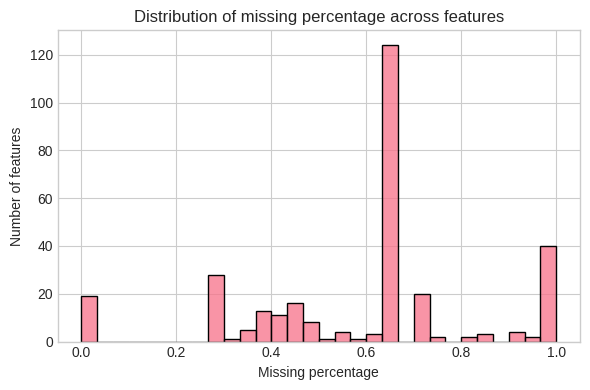

In [34]:
# Compute missing percentage per feature (X only, not the target)
X_only = eda_df.drop(columns=["MathScore"])
missing_pct = X_only.isna().mean().sort_values(ascending=False)

print("Top 25 features by missing percentage:")
display(missing_pct.head(25))

high_missing = missing_pct[missing_pct > 0.98]
print(f"\nNumber of features with > 98% missing: {len(high_missing)}")
display(high_missing)

# Constant or near-constant features
nunique = X_only.nunique(dropna=False)
constant_cols = nunique[nunique <= 1].index.tolist()
print(f"\nNumber of constant features (<=1 unique value): {len(constant_cols)}")
print("Example constant features:", constant_cols[:10])

# Simple visualization of missingness distribution
plt.figure(figsize=(6, 4))
sns.histplot(missing_pct, bins=30)
plt.title("Distribution of missing percentage across features")
plt.xlabel("Missing percentage")
plt.ylabel("Number of features")
plt.tight_layout()
plt.show()


### 1.5 Correlation with MathScore and potential leakage

Some features (especially item-level scores or overall math performance indices) may be **extremely correlated** with `MathScore`.

- This is great for pure prediction,
- But if the task is to understand how **background factors, habits, and school climate** relate to performance, using direct test scores as predictors can be seen as **label leakage**.

We compute correlations between numeric features and `MathScore`, and inspect the most strongly related ones.


In [35]:
# Numeric columns only (including Year, IDs if numeric)
num_cols = eda_df.select_dtypes(include=[np.number]).columns.tolist()

# Avoid including the ID column as a predictor; but it's fine for correlation inspection
# Compute correlation with MathScore
corr_series = (
    eda_df[num_cols]
    .corr()["MathScore"]
    .drop("MathScore")
    .sort_values(ascending=False)
)

print("Top 20 positively correlated features with MathScore:")
display(corr_series.head(20))

print("\nTop 20 negatively correlated features with MathScore:")
display(corr_series.tail(20))


Top 20 positively correlated features with MathScore:


,MathScore
reading_q14_total_timing,0.730747
math_q16_average_score,0.597139
math_q15_average_score,0.533949
math_q2_average_score,0.438035
math_q3_average_score,0.420541
math_q14_average_score,0.414658
math_q12_average_score,0.413307
math_q13_average_score,0.406902
math_q11_average_score,0.396575
math_q7_average_score,0.384159



Top 20 negatively correlated features with MathScore:


,MathScore
math_q21_average_score,NaN
science_q13_average_score,NaN
science_q14_average_score,NaN
science_q15_average_score,NaN
science_q16_average_score,NaN
science_q17_average_score,NaN
science_q18_average_score,NaN
science_q19_average_score,NaN
math_q17_total_timing,NaN
math_q18_total_timing,NaN


Top correlated features to inspect: ['reading_q14_total_timing', 'math_q16_average_score', 'math_q15_average_score', 'math_q2_average_score', 'math_q3_average_score']


/tmp/ipython-input-2250035217.py:7: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=eda_df, x=feat, hue="Year", common_norm=False)


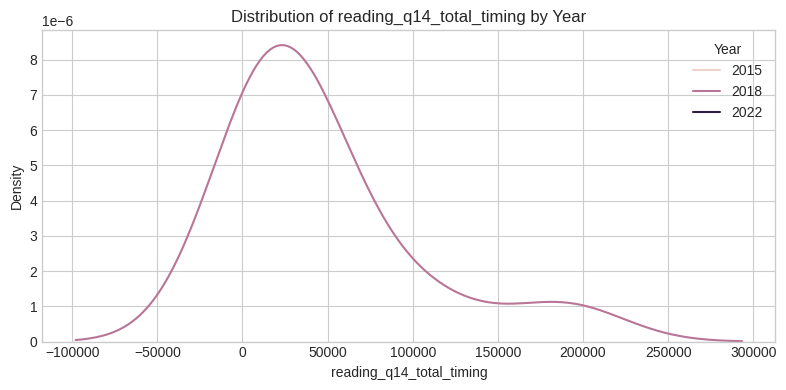

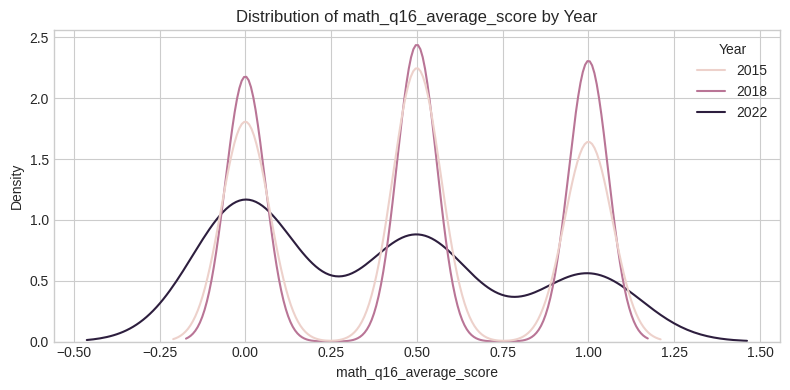

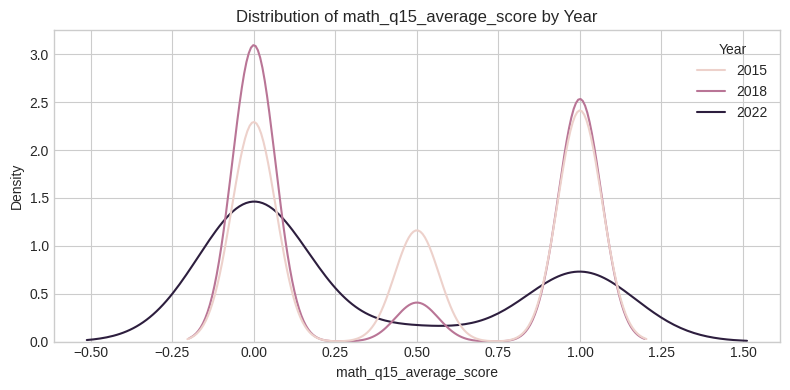

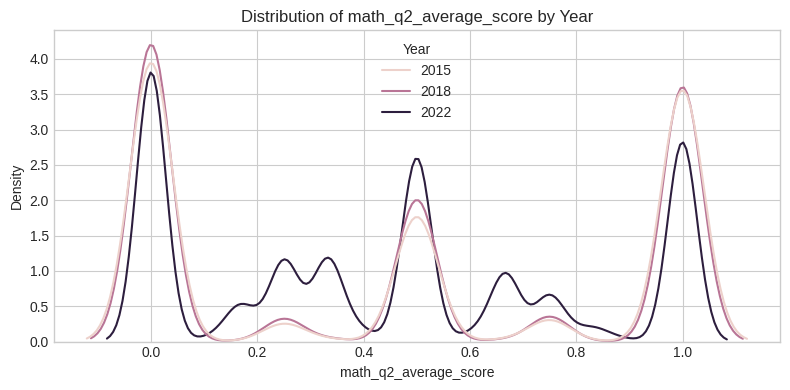

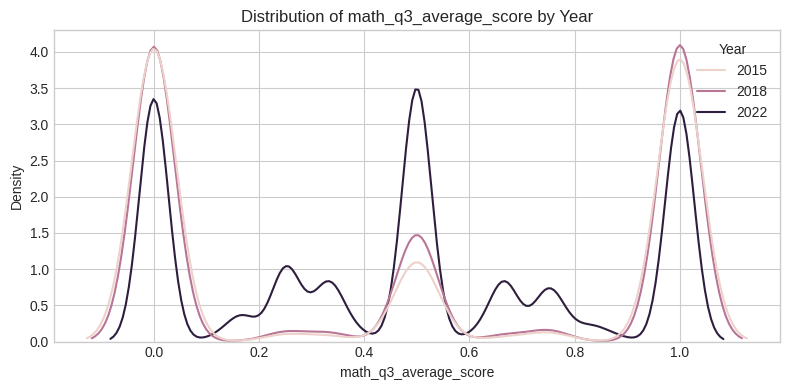

In [36]:
# Inspect distributions of a few top correlated features by Year
top_corr_features = corr_series.head(5).index.tolist()
print("Top correlated features to inspect:", top_corr_features)

for feat in top_corr_features:
    plt.figure(figsize=(8, 4))
    sns.kdeplot(data=eda_df, x=feat, hue="Year", common_norm=False)
    plt.title(f"Distribution of {feat} by Year")
    plt.tight_layout()
    plt.show()


### 1.6 Categorical features: cardinality and rare categories

Many questionnaire variables are categorical (Likert scales, yes/no, etc.). Some may have:

- Very high **cardinality** (many distinct values),
- Very rare categories.

This impacts how we encode them and can increase model complexity.
We inspect a few examples.


In [37]:
cat_cols = eda_df.select_dtypes(include=["object"]).columns.tolist()
print(f"Number of categorical features: {len(cat_cols)}")
print("Example categorical columns:", cat_cols[:10])

# Cardinality
cardinality = eda_df[cat_cols].nunique().sort_values(ascending=False)
print("\nTop 15 categorical features by cardinality:")
display(cardinality.head(15))

# For a couple of medium-cardinality variables, show value counts
example_cats = cardinality[cardinality.between(3, 15)].head(3).index.tolist()
for col in example_cats:
    print(f"\nValue counts for {col}:")
    display(eda_df[col].value_counts(dropna=False).head(20))


Number of categorical features: 3
Example categorical columns: ['CNT', 'CYC', 'STRATUM']

Top 15 categorical features by cardinality:


,0
STRATUM,2731
CNT,98
CYC,3



Value counts for CYC:


,count
CYC,
08MS,412647
07MS,411320
06MS,348119


### 1.7 EDA summary – main issues and modelling implications

From this exploratory analysis, we identify several important points:

1. **Strong distribution shift across PISA cycles**
   - 2015 and 2018 show a large spike at `MathScore = 0` and a long heavy tail of high scores.
   - 2022 has a more regular, unimodal distribution with far fewer zeros.
   - A single global model must compromise between these regimes, which motivates year-aware evaluations and models.

2. **Zero-inflation in 2015/2018**
   - A high proportion of students have `MathScore = 0` in earlier cycles.
   - This suggests considering a **two-part (hurdle) model** or at least explicitly monitoring how the model behaves on zeros.

3. **Missingness and sparse features**
   - Several features have > 98% missing values and can be safely dropped without losing information.
   - Some features are constant or nearly constant and do not contribute to prediction.

4. **Potential leakage from item-level scores**
   - Many item-level scores (e.g. `math_*_average_score`, `*_overall` indices) are extremely correlated with `MathScore`.
   - These are legitimate for prediction, but if the goal is to understand how **background factors** explain performance, we may want to:
     - Run separate experiments **without direct math item features**, or
     - Clearly distinguish “background-only” vs “test-behaviour” models.

5. **Country and year imbalance**
   - Some countries and years have much larger sample sizes.
   - This can bias a global model towards majority countries/years, so:
     - Reporting **per-year** metrics is essential,
     - Optional: use **reweighting** or stratified analysis when drawing conclusions.

6. **Categorical complexity**
   - Many questionnaire variables are categorical with non-trivial cardinality.
   - This impacts the choice of encoding (target encoding, tree-based models with categorical support, etc.) and further motivates using **gradient boosting / tree-based methods** rather than pure linear models.


In our case we decided to use tree based methods as we have many features and we didn't use PCA or dimensional reduction methods as the tree based method already treat that by selecting the most impactful features.

These observations motivate the year-wise experiments and model variants implemented later in the notebook (z-score targets, hurdle model, reweighting, per-year calibration), and provide a solid narrative bridge from data understanding to modelling choices for the hackathon.


## 2. Data Loading and Preprocessing

In [4]:
# Load and preprocess training data
df = pd.read_csv('/content/drive/MyDrive/HiParis/X_train.csv')
y_train_full = pd.read_csv('/content/drive/MyDrive/HiParis/y_train.csv')
print(f"Raw X_train: {df.shape}, y_train: {y_train_full.shape}")

# Keep Year separately for year-wise experiments (preprocess_data will drop it)
train_year = df['Year'].copy()

# Preprocess features (drops Year, IDs, math items, etc.)
X = preprocess_data(df, is_training=True)

# Use MathScore as a 1D Series target
y = y_train_full['MathScore'].astype(float)

# Target encoding for CNT (country)
country_means = y.groupby(X['CNT'], observed=True).mean().squeeze().to_dict()
global_mean = float(y.values.mean())
X['CNT_Encoded'] = X['CNT'].map(country_means).astype(float)
X = X.drop('CNT', axis=1)

# Sample weights - under-weight year 2022
WEIGHT_2022 = 0.75
sample_weights = np.where(train_year == 2022, WEIGHT_2022, 1.0) if train_year is not None else None

if train_year is not None:
    print(f"\nSample weighting: Year 2022 ({(train_year == 2022).sum():,} samples) at {WEIGHT_2022}")

print(f"Final features: {X.shape}, Countries encoded: {len(country_means)}")

Raw X_train: (1172086, 307), y_train: (1172086, 2)
Preprocessed training data: (1172086, 195)

Sample weighting: Year 2022 (412,647 samples) at 0.75
Final features: (1172086, 195), Countries encoded: 98


In [5]:
# Apply feature engineering
X, new_feature_names = create_interaction_features(X)
print(f"Created {len(new_feature_names)} engineered features")
print(f"Total features: {X.shape[1]}")

Created 65 engineered features
Total features: 260


## 3. Model Training

In [6]:
# Train XGBoost model
print(f"Training XGBoost (Year 2022 weight: {WEIGHT_2022})...")

model_full = XGBRegressor(
    n_estimators=1500,
    learning_rate=0.05,
    tree_method="hist",
    enable_categorical=True,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    random_state=10
)

model_full.fit(X, y, sample_weight=sample_weights)
print("Model trained!")

Training XGBoost (Year 2022 weight: 0.75)...
Model trained!


## 4. Model Visualization

XGBoost Results (Full Training Set):
  R² = 0.8533
  RMSE = 46.7929
  MAE = 27.7162


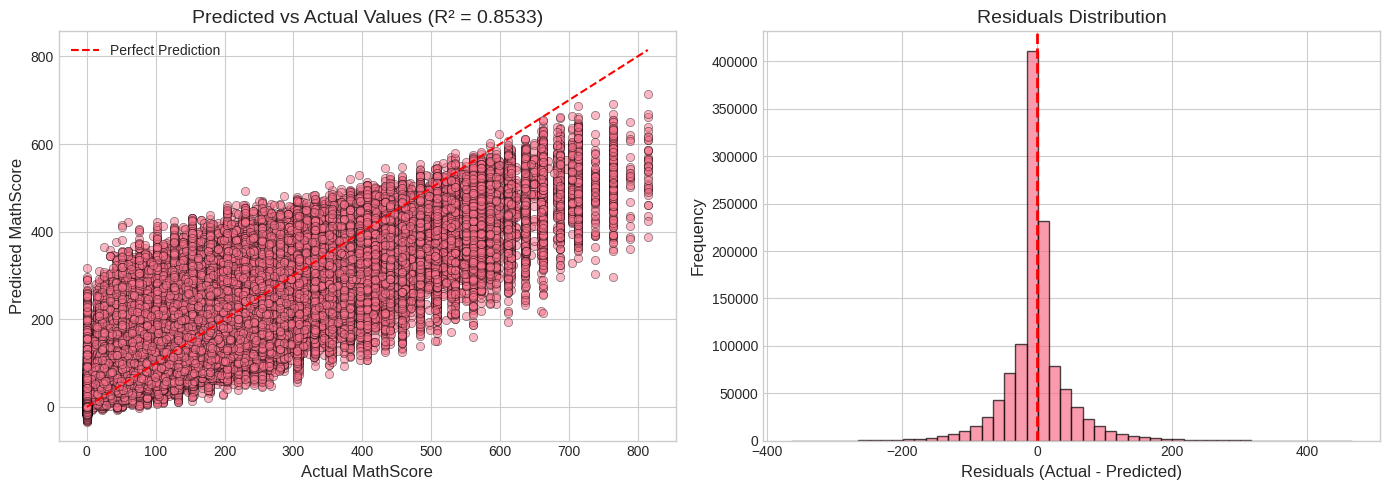

In [7]:
# Visualize Prediction vs Actual Values (on full training set)
y_pred_train = model_full.predict(X)
r2 = r2_score(y, y_pred_train)
rmse = np.sqrt(mean_squared_error(y, y_pred_train))
mae = mean_absolute_error(y, y_pred_train)

print(f"XGBoost Results (Full Training Set):")
print(f"  R² = {r2:.4f}")
print(f"  RMSE = {rmse:.4f}")
print(f"  MAE = {mae:.4f}")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot of predictions vs actual
axes[0].scatter(y, y_pred_train, alpha=0.5, edgecolors='k', linewidth=0.5)
axes[0].plot([y.values.min(), y.values.max()],
             [y.values.min(), y.values.max()], 'r--', label='Perfect Prediction')
axes[0].set_xlabel('Actual MathScore', fontsize=12)
axes[0].set_ylabel('Predicted MathScore', fontsize=12)
axes[0].set_title(f'Predicted vs Actual Values (R² = {r2:.4f})', fontsize=14)
axes[0].legend()

# Residuals distribution
residuals = y.values.flatten() - y_pred_train
axes[1].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
axes[1].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[1].set_xlabel('Residuals (Actual - Predicted)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Residuals Distribution', fontsize=14)

plt.tight_layout()
plt.show()

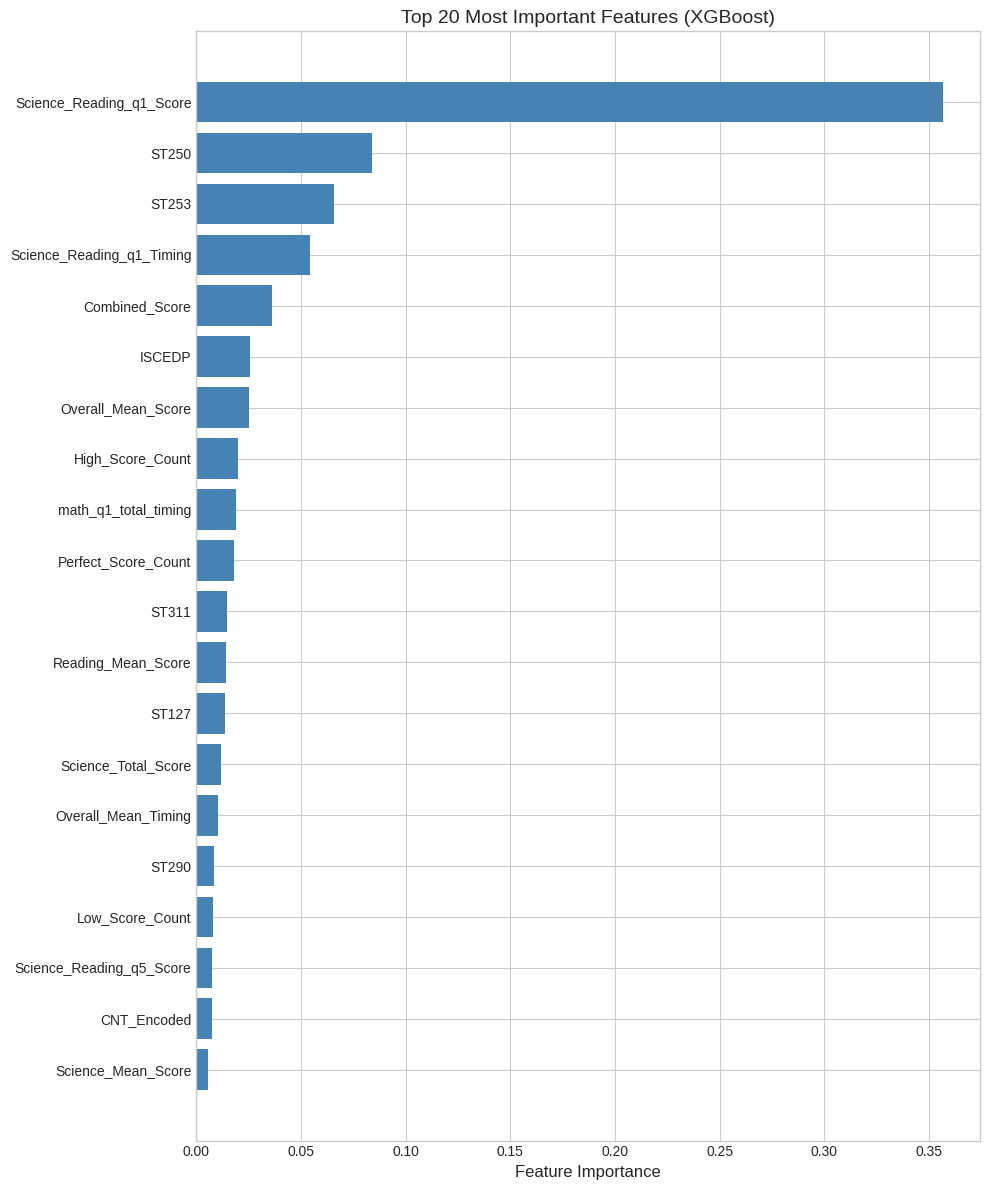

In [8]:
# Feature Importance Plot (XGBoost built-in)
fig, ax = plt.subplots(figsize=(10, 12))
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model_full.feature_importances_
}).sort_values('importance', ascending=True).tail(20)

ax.barh(feature_importance['feature'], feature_importance['importance'], color='steelblue')
ax.set_xlabel('Feature Importance', fontsize=12)
ax.set_title('Top 20 Most Important Features (XGBoost)', fontsize=14)
plt.tight_layout()
plt.show()

## 5. SHAP Analysis for Model Interpretability

In [9]:
# Compute SHAP values for model interpretability
print("Computing SHAP values (this may take a moment)...")

explainer = shap.TreeExplainer(model_full)
sample_size = min(500, len(X))
X_sample = X.sample(n=sample_size, random_state=42)
shap_values = explainer.shap_values(X_sample)

print(f"SHAP values computed for {sample_size} samples")

Computing SHAP values (this may take a moment)...
SHAP values computed for 500 samples


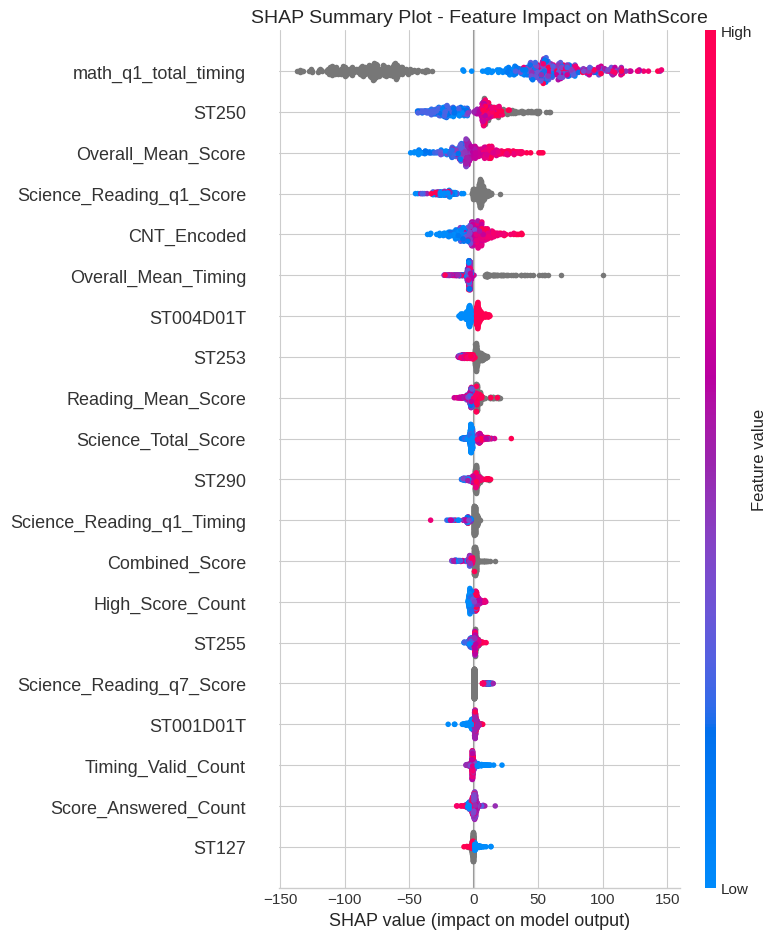

In [10]:
# SHAP Summary Plot - Shows feature importance and impact direction
plt.figure(figsize=(12, 10))
shap.summary_plot(shap_values, X_sample, plot_type="dot", show=False, max_display=20)
plt.title("SHAP Summary Plot - Feature Impact on MathScore", fontsize=14)
plt.tight_layout()
plt.show()

SHAP Waterfall Plot - Single Prediction Explanation


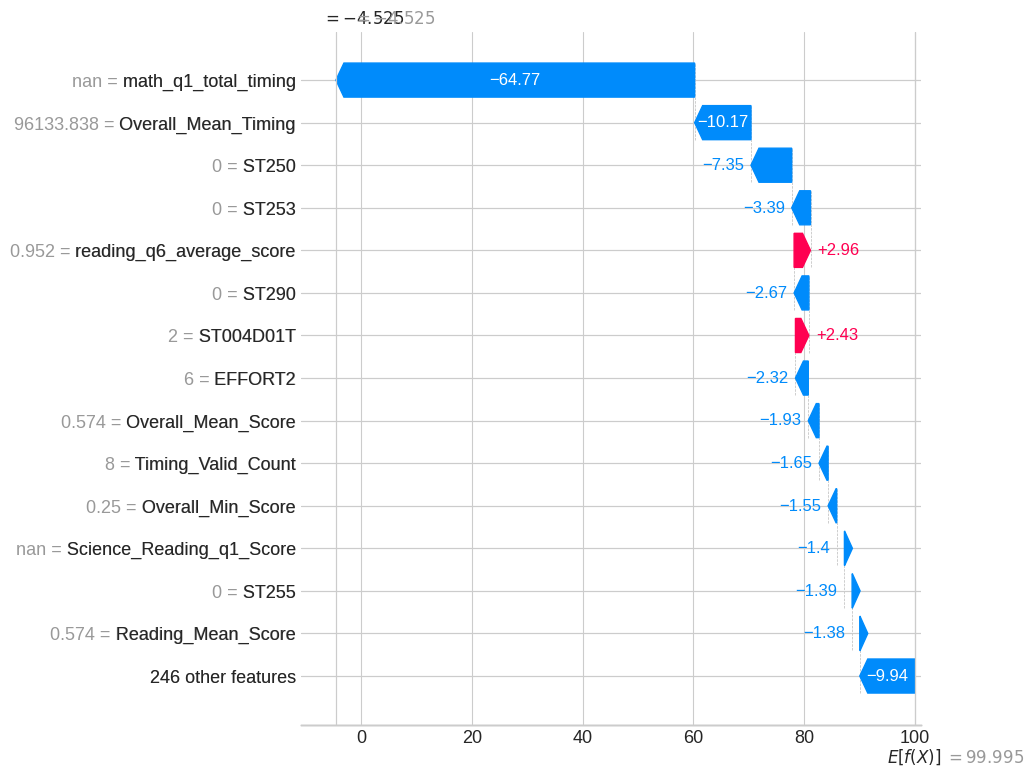

In [11]:
# SHAP Waterfall Plot - Explain a single prediction
# Shows how each feature contributes to moving from the base value to the prediction
print("SHAP Waterfall Plot - Single Prediction Explanation")
shap.plots.waterfall(shap.Explanation(values=shap_values[0],
                                       base_values=explainer.expected_value,
                                       data=X_sample.iloc[0],
                                       feature_names=X_sample.columns.tolist()),
                     max_display=15)

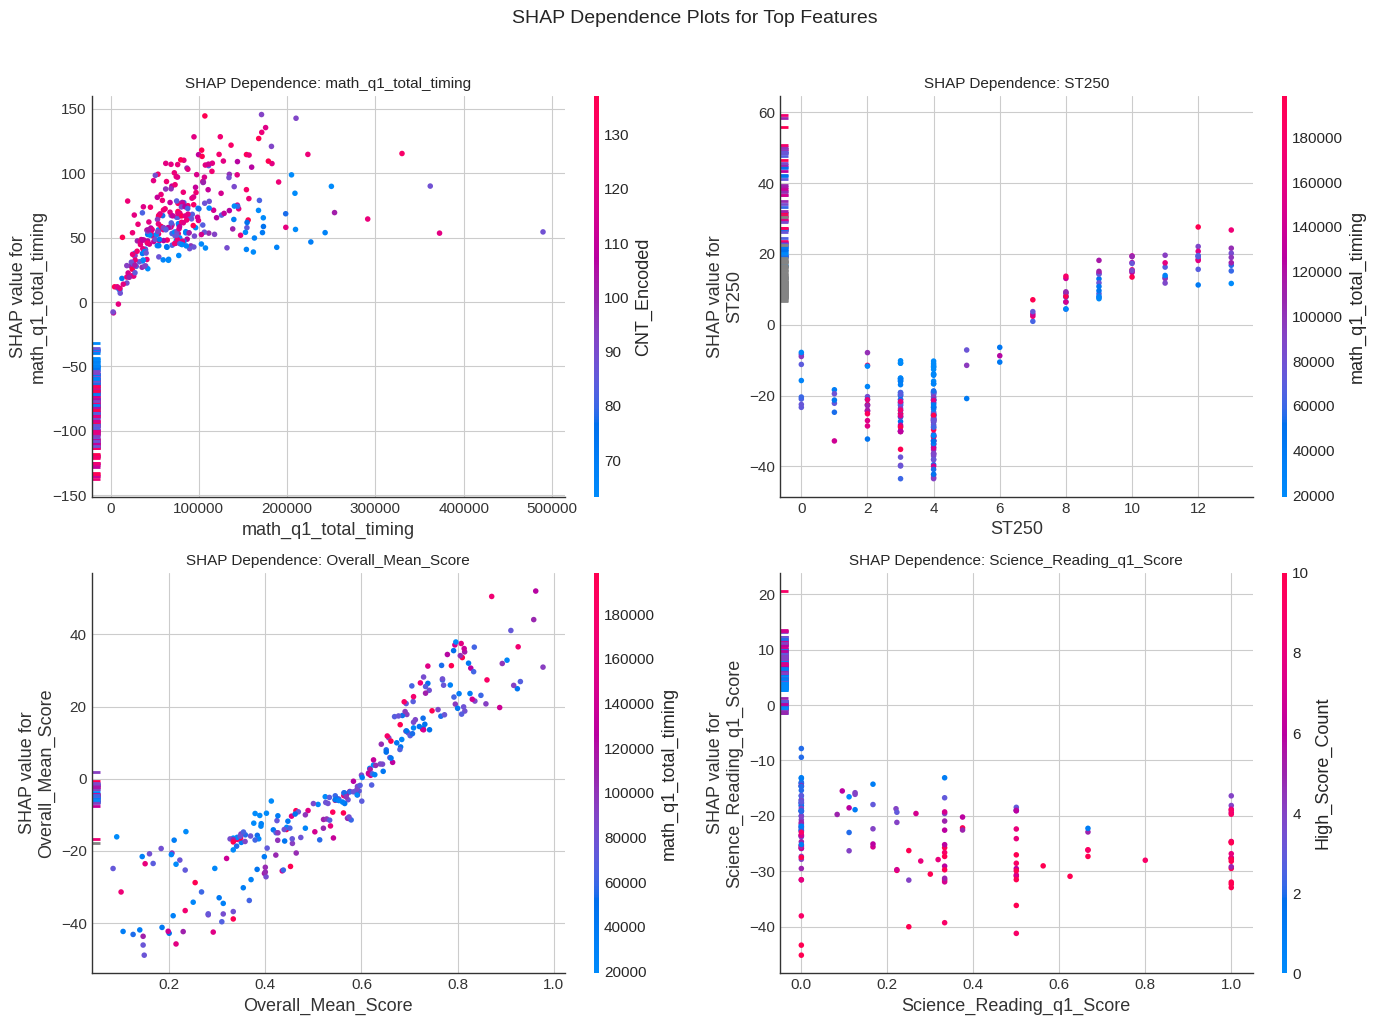

In [12]:
# SHAP Dependence Plots - Show how top features affect predictions
shap_importance = pd.DataFrame({
    'feature': X_sample.columns,
    'importance': np.abs(shap_values).mean(axis=0)
}).sort_values('importance', ascending=False)

top_features = shap_importance.head(4)['feature'].tolist()
numeric_features = X_sample.select_dtypes(include=[np.number]).columns.tolist()
top_numeric_features = [f for f in top_features if f in numeric_features][:4]

if len(top_numeric_features) >= 2:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    for idx, feature in enumerate(top_numeric_features[:4]):
        plt.sca(axes.flatten()[idx])
        shap.dependence_plot(feature, shap_values, X_sample, show=False, ax=axes.flatten()[idx])
        axes.flatten()[idx].set_title(f'SHAP Dependence: {feature}', fontsize=11)
    plt.suptitle('SHAP Dependence Plots for Top Features', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()
else:
    print("Not enough numeric features for dependence plots")

## 6. Generate Final Predictions

In [14]:
# Load and preprocess test data
X_test_raw = pd.read_csv('/content/drive/MyDrive/HiParis/X_test.csv')
print(f"Raw test set: {X_test_raw.shape}")

X_test_processed, id_col = preprocess_data(X_test_raw, is_training=False)

# Apply target encoding
X_test_processed['CNT_Encoded'] = X_test_processed['CNT'].map(country_means).astype(float).fillna(global_mean)
X_test_processed = X_test_processed.drop('CNT', axis=1)

# Apply feature engineering
X_test_processed, _ = create_interaction_features(X_test_processed)

# Align features with training set
X_test_processed = X_test_processed[[f for f in X.columns if f in X_test_processed.columns]]
print(f"Test set ready: {X_test_processed.shape}")

Raw test set: (586044, 307)
Preprocessed test data: (586044, 195)
Test set ready: (586044, 260)


In [15]:
# Generate predictions
y_pred_test = model_full.predict(X_test_processed)

In [16]:
# Post-processing: Clip predictions to training distribution
train_1pct = np.percentile(y.values, 1)

print(f"Training 1st percentile: {train_1pct:.2f}")
print(f"Predictions below 1st percentile: {(y_pred_test < train_1pct).sum()}")

y_pred_test = np.clip(y_pred_test, train_1pct, None)

df_pred = pd.DataFrame({"ID": id_col, "MathScore": y_pred_test})
print(f"\nGenerated {len(y_pred_test)} predictions (min clipped to {train_1pct:.2f})")
print(df_pred.describe())

Training 1st percentile: 0.00
Predictions below 1st percentile: 106808

Generated 586044 predictions (min clipped to 0.00)
                 ID      MathScore
count  5.860440e+05  586044.000000
mean   8.795681e+05     100.525197
std    5.075177e+05     107.701762
min    2.000000e+00       0.000000
25%    4.404968e+05       1.087587
50%    8.795360e+05      80.595703
75%    1.318993e+06     153.651134
max    1.758129e+06     622.700562


In [17]:
# Save submission to CSV file
df_pred.to_csv("submission.csv", index=False)
print("Predictions saved to submission.csv")
df_pred

Predictions saved to submission.csv


,ID,MathScore
0,412660,133.406021
1,554658,88.638870
2,937138,0.000000
3,752986,275.097900
4,1084508,150.141037
...,...,...
586039,1757496,180.434128
586040,1414197,0.801788
586041,821972,256.202606
586042,25376,67.793701


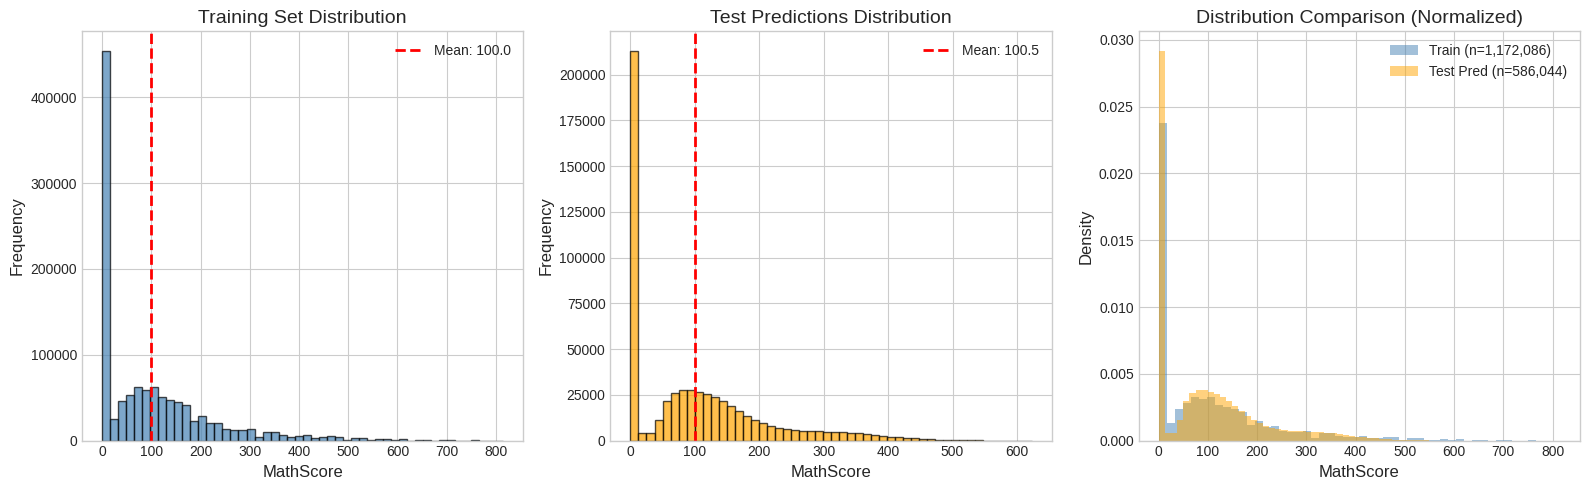


Distribution Statistics Comparison:
Metric              Training  Predictions
--------------------------------------------------
Mean                  100.00       100.53
Std                   122.18       107.70
Min                     0.00         0.00
25%                     0.00         1.09
50%                    66.05        80.60
75%                   152.81       153.65
Max                   814.97       622.70


In [18]:
# Distribution comparison: Training vs Predictions
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# 1. Training target distribution
axes[0].hist(y.values.flatten(), bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].axvline(x=y.values.mean(), color='r', linestyle='--', linewidth=2, label=f'Mean: {y.values.mean():.1f}')
axes[0].set_xlabel('MathScore', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Training Set Distribution', fontsize=14)
axes[0].legend()

# 2. Test predictions distribution
axes[1].hist(y_pred_test, bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[1].axvline(x=y_pred_test.mean(), color='r', linestyle='--', linewidth=2, label=f'Mean: {y_pred_test.mean():.1f}')
axes[1].set_xlabel('MathScore', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Test Predictions Distribution', fontsize=14)
axes[1].legend()

# 3. Overlay comparison
axes[2].hist(y.values.flatten(), bins=50, alpha=0.5, color='steelblue', label=f'Train (n={len(y):,})', density=True)
axes[2].hist(y_pred_test, bins=50, alpha=0.5, color='orange', label=f'Test Pred (n={len(y_pred_test):,})', density=True)
axes[2].set_xlabel('MathScore', fontsize=12)
axes[2].set_ylabel('Density', fontsize=12)
axes[2].set_title('Distribution Comparison (Normalized)', fontsize=14)
axes[2].legend()

plt.tight_layout()
plt.show()

# Print statistics comparison
print("\n" + "=" * 50)
print("Distribution Statistics Comparison:")
print("=" * 50)
print(f"{'Metric':<15} {'Training':>12} {'Predictions':>12}")
print("-" * 50)
print(f"{'Mean':<15} {y.values.mean():>12.2f} {y_pred_test.mean():>12.2f}")
print(f"{'Std':<15} {y.values.std():>12.2f} {y_pred_test.std():>12.2f}")
print(f"{'Min':<15} {y.values.min():>12.2f} {y_pred_test.min():>12.2f}")
print(f"{'25%':<15} {np.percentile(y.values, 25):>12.2f} {np.percentile(y_pred_test, 25):>12.2f}")
print(f"{'50%':<15} {np.percentile(y.values, 50):>12.2f} {np.percentile(y_pred_test, 50):>12.2f}")
print(f"{'75%':<15} {np.percentile(y.values, 75):>12.2f} {np.percentile(y_pred_test, 75):>12.2f}")
print(f"{'Max':<15} {y.values.max():>12.2f} {y_pred_test.max():>12.2f}")

DISTRIBUTION BY YEAR

Training Set MathScore by Year:
  2015: n=348,119, mean=100.1, std=151.0
  2018: n=411,320, mean=100.0, std=139.8
  2022: n=412,647, mean=99.9, std=60.9

Test Predictions by Year:
  2015: n=174,102, mean=100.7, std=133.9
  2018: n=205,889, mean=100.6, std=124.3
  2022: n=206,053, mean=100.2, std=49.1


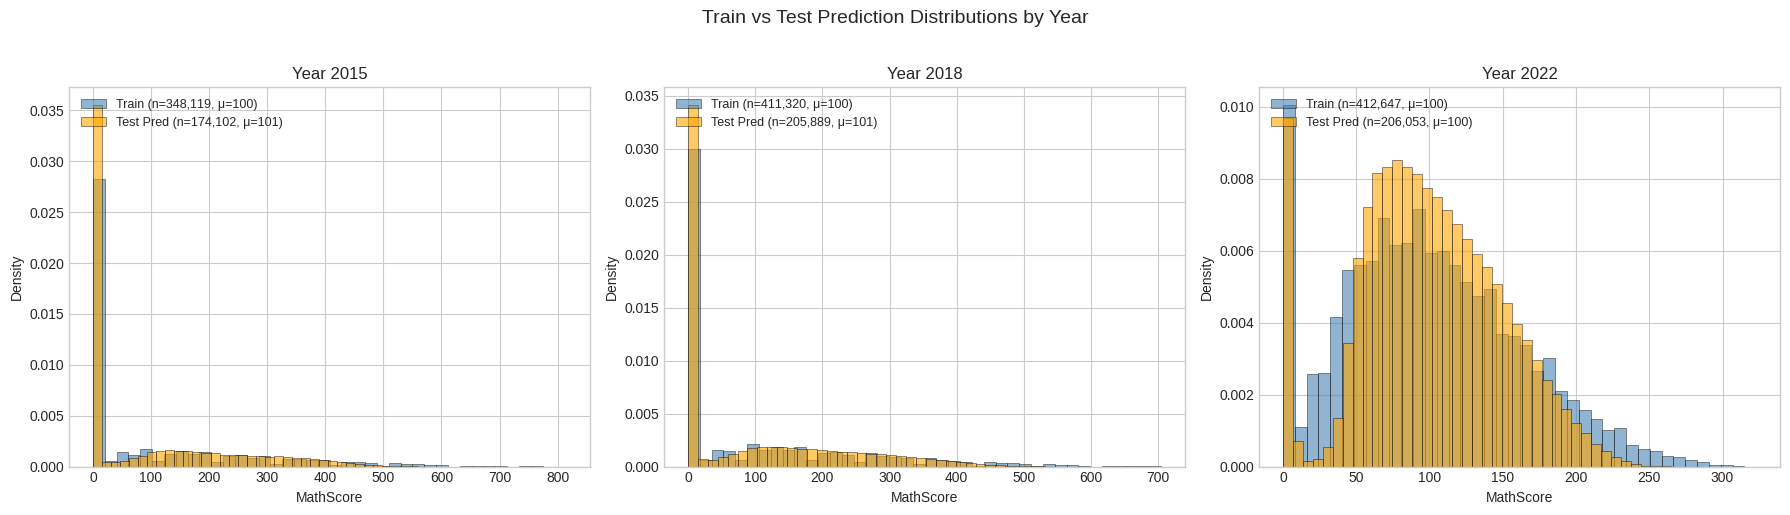

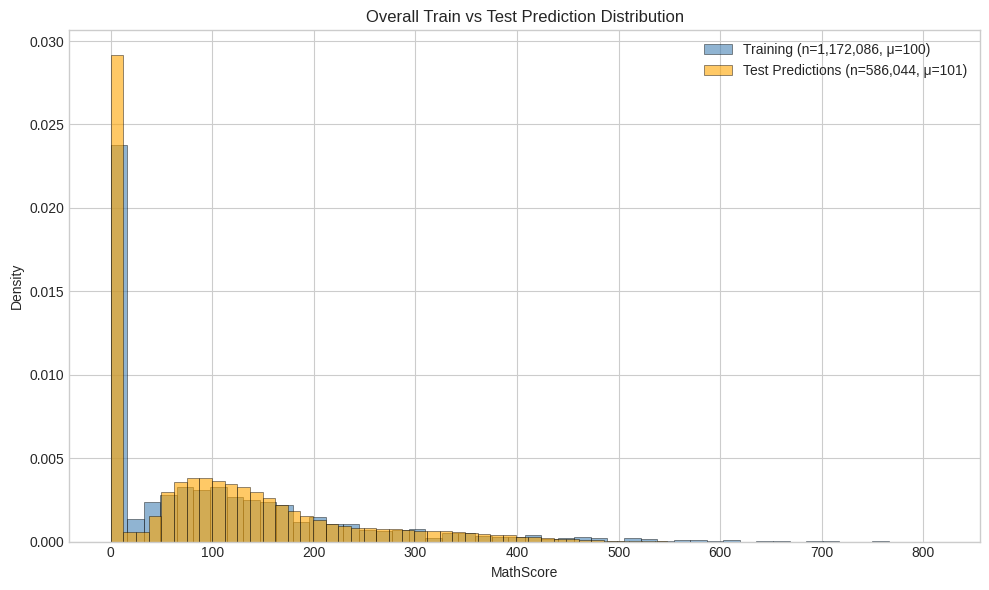

In [19]:
# Distribution by Year - Superposed
df_raw_train = pd.read_csv('/content/drive/MyDrive/HiParis/X_train.csv')
df_raw_test = pd.read_csv('/content/drive/MyDrive/HiParis/X_test.csv')
y_raw = pd.read_csv('/content/drive/MyDrive/HiParis/y_train.csv')

train_years = df_raw_train['Year'] if 'Year' in df_raw_train.columns else None
test_years = df_raw_test['Year'] if 'Year' in df_raw_test.columns else None

if train_years is not None:
    unique_train_years = sorted(train_years.unique())
    unique_test_years = sorted(test_years.unique()) if test_years is not None else []
    all_years = sorted(set(unique_train_years) | set(unique_test_years))

    print("=" * 50)
    print("DISTRIBUTION BY YEAR")
    print("=" * 50)

    print("\nTraining Set MathScore by Year:")
    for year in unique_train_years:
        mask = train_years == year
        scores = y_raw.drop(columns=['Unnamed: 0']).values[mask].flatten()
        print(f"  {year}: n={mask.sum():,}, mean={scores.mean():.1f}, std={scores.std():.1f}")

    if test_years is not None:
        print("\nTest Predictions by Year:")
        for year in unique_test_years:
            mask = test_years == year
            preds = y_pred_test[mask]
            print(f"  {year}: n={mask.sum():,}, mean={preds.mean():.1f}, std={preds.std():.1f}")

    # Plot per year
    n_years = len(all_years)
    fig, axes = plt.subplots(1, n_years, figsize=(6*n_years, 5))
    if n_years == 1:
        axes = [axes]

    for i, year in enumerate(all_years):
        ax = axes[i]
        if year in unique_train_years:
            mask = train_years == year
            scores = y_raw.drop(columns=['Unnamed: 0']).values[mask].flatten()
            ax.hist(scores, bins=40, alpha=0.6, color='steelblue',
                    label=f'Train (n={mask.sum():,}, μ={scores.mean():.0f})',
                    edgecolor='black', linewidth=0.5, density=True)
        if test_years is not None and year in unique_test_years:
            mask = test_years == year
            preds = y_pred_test[mask]
            ax.hist(preds, bins=40, alpha=0.6, color='orange',
                    label=f'Test Pred (n={mask.sum():,}, μ={preds.mean():.0f})',
                    edgecolor='black', linewidth=0.5, density=True)
        ax.set_xlabel('MathScore')
        ax.set_ylabel('Density')
        ax.set_title(f'Year {year}')
        ax.legend(loc='upper left', fontsize=9)

    plt.suptitle('Train vs Test Prediction Distributions by Year', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

    # Overall superposed
    fig, ax = plt.subplots(figsize=(10, 6))
    y_train_all = y_raw.drop(columns=['Unnamed: 0']).values.flatten()
    ax.hist(y_train_all, bins=50, alpha=0.6, color='steelblue',
            label=f'Training (n={len(y_train_all):,}, μ={y_train_all.mean():.0f})',
            edgecolor='black', linewidth=0.5, density=True)
    ax.hist(y_pred_test, bins=50, alpha=0.6, color='orange',
            label=f'Test Predictions (n={len(y_pred_test):,}, μ={y_pred_test.mean():.0f})',
            edgecolor='black', linewidth=0.5, density=True)
    ax.set_xlabel('MathScore')
    ax.set_ylabel('Density')
    ax.set_title('Overall Train vs Test Prediction Distribution')
    ax.legend()
    plt.tight_layout()
    plt.show()
else:
    print("Year column not found")

# Other approaches year per year

## 3bis. Year-wise Experiments: Handling Distribution Shift Across PISA Cycles

In the exploratory analysis, we saw a **strong distribution shift** in `MathScore` across PISA cycles:

* **2015 & 2018**: many students with score exactly `0`, plus a long heavy tail of high scores.
* **2022**: a more regular, unimodal distribution centered around ~100.

A single global model trained on all years has to compromise between these very different regimes. That leads to:

* Good global metrics, but
* Predictions in 2015/2018 that are **compressed toward 0** (because half the students are at 0), and
* Classic regression-to-the-mean behaviour.

To understand and mitigate this, we run several **year-aware experiments**:

1. Baseline global model on raw `MathScore`.
2. Global model on year-normalized target (z-score)**.
3. Hurdle model that explicitly separates `P(y = 0)` from `E[y | y > 0]`.
4. Global model with sample reweighting by year.
5. Per-year linear calibration of baseline predictions.

We keep the same train/validation split across all experiments and report per-year metrics to see which strategy handles each cycle best.



In [22]:
# Split into training and validation sets (keep Year for each sample)
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val, year_train_tr, year_val = train_test_split(
    X, y, train_years,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

print(f"Training set: {X_train.shape[0]} samples, {X_train.shape[1]} features")
print(f"Validation set: {X_val.shape[0]} samples")
print("Years in train:", sorted(year_train_tr.unique()))
print("Years in val  :", sorted(year_val.unique()))


Training set: 937668 samples, 260 features
Validation set: 234418 samples
Years in train: [np.int64(2015), np.int64(2018), np.int64(2022)]
Years in val  : [np.int64(2015), np.int64(2018), np.int64(2022)]


In [24]:
# Train XGBoost model
model = XGBRegressor(
    n_estimators=1500,
    learning_rate=0.05,
    tree_method="hist",
    enable_categorical=True,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    random_state=10
)

print("Training XGBoost...")
model.fit(X_train, y_train)

y_pred_val = model.predict(X_val)
r2 = r2_score(y_val, y_pred_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
mae = mean_absolute_error(y_val, y_pred_val)

print(f"\nXGBoost Results:")
print(f"  R² = {r2:.4f}")
print(f"  RMSE = {rmse:.4f}")
print(f"  MAE = {mae:.4f}")

Training XGBoost...

XGBoost Results:
  R² = 0.7864
  RMSE = 56.4006
  MAE = 32.6610


In [25]:
from xgboost import XGBClassifier
from sklearn.linear_model import LinearRegression

def compute_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return rmse, mae, r2

results = []
unique_years = sorted(year_val.unique())
print("Years in validation set:", unique_years)

# -----------------------------
# 0. Baseline (raw target)
# -----------------------------
print("\n[0] Baseline XGBoost (raw MathScore) – per-year metrics")

for yr in unique_years:
    mask = (year_val == yr)
    rmse, mae, r2 = compute_metrics(y_val[mask], y_pred_val[mask])
    print(f"  Year {int(yr)} → RMSE={rmse:.2f}, MAE={mae:.2f}, R²={r2:.4f}")
    results.append({
        "approach": "baseline_raw",
        "year": int(yr),
        "rmse": rmse,
        "mae": mae,
        "r2": r2,
    })


Years in validation set: [np.int64(2015), np.int64(2018), np.int64(2022)]

[0] Baseline XGBoost (raw MathScore) – per-year metrics
  Year 2015 → RMSE=68.09, MAE=36.28, R²=0.7946
  Year 2018 → RMSE=62.15, MAE=34.97, R²=0.8028
  Year 2022 → RMSE=35.67, MAE=27.30, R²=0.6592


This cell computes baseline metrics per year using the already-trained global XGBoost (y_pred_val). It also initializes a results list to collect metrics from all subsequent experiments.

## Year-Normalized Target

We now train a global model on z-scored MathScore inside each year, so the model learns to predict relative performance within a cycle, then map it back to the original scale.

In [42]:
print("\n Global model on year-wise z-score target")

import numpy as np
import pandas as pd
from xgboost import XGBRegressor

# --- 1. Force everything to be 1D Series cleanly ---
y_train_arr       = np.asarray(y_train).reshape(-1)         # (n, 1) -> (n,)
year_train_arr    = np.asarray(year_train_tr).reshape(-1)   # (n, 1) -> (n,)
y_val_arr         = np.asarray(y_val).reshape(-1)
year_val_arr      = np.asarray(year_val).reshape(-1)

y_train     = pd.Series(y_train_arr, name="MathScore")
year_train_tr = pd.Series(year_train_arr, name="Year")
y_val       = pd.Series(y_val_arr, name="MathScore")
year_val    = pd.Series(year_val_arr, name="Year")

print("y_train shape:", y_train.shape)
print("year_train_tr shape:", year_train_tr.shape)

# --- 2. Compute per-year mean / std on TRAIN ---
train_df_stats = pd.DataFrame({
    "MathScore": y_train,
    "Year": year_train_tr
})

year_stats = train_df_stats.groupby("Year")["MathScore"].agg(["mean", "std"])

# Avoid division by zero in weird cases
year_stats["std"] = year_stats["std"].replace(0, 1e-6)

# --- 3. Build z-scored target for TRAIN ---
y_train_z = (
    y_train - year_train_tr.map(year_stats["mean"])
) / year_train_tr.map(year_stats["std"])

# --- 4. Train global model on z-score target ---
model_z = XGBRegressor(
    n_estimators=1500,
    learning_rate=0.05,
    tree_method="hist",
    enable_categorical=True,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=10,
)

model_z.fit(X_train, y_train_z)

# --- 5. Predict on VAL in z-space, then de-normalise per year ---
y_val_z_pred = model_z.predict(X_val)

mean_val = year_val.map(year_stats["mean"]).to_numpy()
std_val  = year_val.map(year_stats["std"]).to_numpy()

y_val_pred_z = y_val_z_pred * std_val + mean_val  # back to MathScore scale

# --- 6. Per-year metrics ---
for yr in unique_years:
    mask = (year_val == yr)
    rmse, mae, r2 = compute_metrics(y_val[mask], y_val_pred_z[mask])
    print(f"  Year {int(yr)} → RMSE={rmse:.2f}, MAE={mae:.2f}, R²={r2:.4f}")
    results.append({
        "approach": "zscore_global",
        "year": int(yr),
        "rmse": rmse,
        "mae": mae,
        "r2": r2,
    })



 Global model on year-wise z-score target
y_train shape: (937668,)
year_train_tr shape: (937668,)
  Year 2015 → RMSE=68.29, MAE=36.32, R²=0.7933
  Year 2018 → RMSE=62.23, MAE=35.01, R²=0.8022
  Year 2022 → RMSE=35.60, MAE=27.27, R²=0.6606


##Hurdle Model for the Zero Spike

2015 and 2018 have a huge spike at MathScore = 0. Instead of asking one regressor to model this mixture, we:

Train a classifier for P(y = 0 | X).

Train a regressor for E[y | y > 0, X].

Combine them as (1 - p_zero) * y_pos_pred.

In [44]:
# -----------------------------
# Hurdle model: P(y=0) + E[y | y>0]
# -----------------------------
print("\n Hurdle model (classifier for zero + regressor for positive scores)")

import numpy as np

# 1) Convert y_train / y_val to flat numpy arrays
y_train_arr = np.asarray(y_train).reshape(-1)
y_val_arr   = np.asarray(y_val).reshape(-1)

# 2) Classifier for "is zero" (labels aligned *by position* with X_train rows)
is_zero_train = (y_train_arr == 0).astype(int)

clf_zero = XGBClassifier(
    n_estimators=400,
    learning_rate=0.05,
    tree_method="hist",
    enable_categorical=True,   # you have categorical features
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=10,
)

clf_zero.fit(X_train, is_zero_train)

# 3) Regressor for y > 0 (positive scores only)
mask_pos_train = (y_train_arr > 0) & ~np.isnan(y_train_arr)

X_pos = X_train.iloc[mask_pos_train]   # positional indexing, no index alignment games
y_pos = y_train_arr[mask_pos_train]    # plain numpy slice

print(f"Positive-score training samples: {X_pos.shape[0]} (out of {X_train.shape[0]})")

reg_pos = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    tree_method="hist",
    enable_categorical=True,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=10,
)

reg_pos.fit(X_pos, y_pos)

# 4) Combine on validation set
p_zero_val = clf_zero.predict_proba(X_val)[:, 1]   # P(y == 0 | X)
y_pos_pred_val = reg_pos.predict(X_val)            # E[y | y>0, X]

y_val_pred_hurdle = (1.0 - p_zero_val) * y_pos_pred_val
y_val_pred_hurdle = np.clip(y_val_pred_hurdle, 0, None)

# 5) Per-year metrics (use numpy arrays for masks)
year_val_arr = np.asarray(year_val).reshape(-1)

for yr in unique_years:
    mask = (year_val_arr == yr)
    rmse, mae, r2 = compute_metrics(y_val_arr[mask], y_val_pred_hurdle[mask])
    print(f"  Year {int(yr)} → RMSE={rmse:.2f}, MAE={mae:.2f}, R²={r2:.4f}")
    results.append({
        "approach": "hurdle",
        "year": int(yr),
        "rmse": rmse,
        "mae": mae,
        "r2": r2,
    })



 Hurdle model (classifier for zero + regressor for positive scores)
Positive-score training samples: 580616 (out of 937668)
  Year 2015 → RMSE=68.12, MAE=34.91, R²=0.7943
  Year 2018 → RMSE=62.22, MAE=33.62, R²=0.8023
  Year 2022 → RMSE=35.81, MAE=27.15, R²=0.6567


## Year Reweighting & Per-Year Calibration

We now test two more ideas:

Reweighting: give each year equal total weight during training so one cycle cannot dominate.

Per-year calibration: learn a simple linear mapping from baseline predictions to true scores inside each year.

In [47]:
print("\n Global model with year reweighting (each year same total weight)")

year_counts = year_train_tr.value_counts()
sample_weight = year_train_tr.map(1.0 / year_counts)

model_weighted = XGBRegressor(
    n_estimators=1500,
    learning_rate=0.05,
    tree_method="hist",
    enable_categorical=True,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=10,
)

model_weighted.fit(X_train, y_train, sample_weight=sample_weight.values)
y_val_pred_weighted = model_weighted.predict(X_val)

for yr in unique_years:
    mask = (year_val == yr)
    rmse, mae, r2 = compute_metrics(y_val[mask], y_val_pred_weighted[mask])
    print(f"  Year {int(yr)} → RMSE={rmse:.2f}, MAE={mae:.2f}, R²={r2:.4f}")
    results.append({
        "approach": "year_reweight",
        "year": int(yr),
        "rmse": rmse,
        "mae": mae,
        "r2": r2,
    })


# -----------------------------
# 4.4 Per-year linear calibration of baseline predictions
# -----------------------------
print("\n[4.4] Per-year linear calibration of BASELINE predictions")

# We reuse the baseline predictions y_pred_val from above
calibrated_val = np.zeros_like(y_pred_val)

for yr in unique_years:
    mask = (year_val == yr)
    if mask.sum() < 30:
        # not enough data: leave predictions as-is
        calibrated_val[mask] = y_pred_val[mask]
        continue

    x = y_pred_val[mask].reshape(-1, 1)
    y_true = y_val[mask].values
    reg_cal = LinearRegression()
    reg_cal.fit(x, y_true)
    calibrated_val[mask] = reg_cal.predict(x)

for yr in unique_years:
    mask = (year_val == yr)
    rmse, mae, r2 = compute_metrics(y_val[mask], calibrated_val[mask])
    print(f"  Year {int(yr)} → RMSE={rmse:.2f}, MAE={mae:.2f}, R²={r2:.4f}")
    results.append({
        "approach": "baseline+calib",
        "year": int(yr),
        "rmse": rmse,
        "mae": mae,
        "r2": r2,
    })


 Global model with year reweighting (each year same total weight)
  Year 2015 → RMSE=94.95, MAE=66.22, R²=0.6005
  Year 2018 → RMSE=86.90, MAE=62.28, R²=0.6144
  Year 2022 → RMSE=54.56, MAE=43.87, R²=0.2028

[4.4] Per-year linear calibration of BASELINE predictions
  Year 2015 → RMSE=68.09, MAE=36.26, R²=0.7946
  Year 2018 → RMSE=62.14, MAE=34.99, R²=0.8028
  Year 2022 → RMSE=35.67, MAE=27.31, R²=0.6592


Reweighting tests whether the model was overfitting to the majority year; calibration gives each year a tiny linear “post-processing” layer.

### Summary Table and Hackathon Narrative

Finally, we collect all metrics and summarize them in tables.

In [48]:
# -----------------------------
# Summary comparison table
# -----------------------------
results_df = pd.DataFrame(results)
print("\n==== All approaches – per-year metrics ====")
print(results_df)

print("\n==== R² by approach and year ====")
print(results_df.pivot_table(index="approach", columns="year", values="r2"))

print("\n==== RMSE by approach and year ====")
print(results_df.pivot_table(index="approach", columns="year", values="rmse"))


==== All approaches – per-year metrics ====
          approach  year       rmse        mae        r2
0     baseline_raw  2015  68.087834  36.276337  0.794552
1     baseline_raw  2018  62.146518  34.970901  0.802786
2     baseline_raw  2022  35.674161  27.302256  0.659206
3    zscore_global  2015  68.292851  36.322690  0.793313
4    zscore_global  2018  62.231287  35.005767  0.802248
5    zscore_global  2022  35.599974  27.265057  0.660622
6           hurdle  2015  68.122693  34.905411  0.794341
7           hurdle  2018  62.215295  33.618991  0.802350
8           hurdle  2022  35.805798  27.147803  0.656686
9    year_reweight  2015  94.945063  66.218757  0.600508
10   year_reweight  2018  86.898118  62.281630  0.614412
11   year_reweight  2022  54.562088  43.872043  0.202801
12  baseline+calib  2015  68.086841  36.263140  0.794558
13  baseline+calib  2018  62.144882  34.988564  0.802797
14  baseline+calib  2022  35.672702  27.312201  0.659234

==== R² by approach and year ====
year    

# Demo

In [49]:
# ============================================================
# Small demo: training & inference on 1000 rows
# Task: Execution of training and inference
# Data preparation limited to first 1000 lines
# ============================================================

import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 1. Load a small subset of the data (REQUIRED FORMAT)
our_df = pd.read_csv("/content/drive/MyDrive/HiParis/X_train.csv", nrows=1000)          # <-- as required
our_y  = pd.read_csv("/content/drive/MyDrive/HiParis/y_train.csv", nrows=1000)["MathScore"]

print("Demo subset shapes:")
print("  our_df :", our_df.shape)
print("  our_y  :", our_y.shape)

# 2. Preprocess using the same functions as the main notebook
#    (assumes preprocess_data and create_interaction_features are already defined above)
year_demo = our_df["Year"].copy() if "Year" in our_df.columns else None
X_demo = preprocess_data(our_df.copy(), is_training=True)
y_demo = our_y.astype(float)

# Simple target encoding for CNT on this subset
if "CNT" in X_demo.columns:
    country_means_demo = y_demo.groupby(X_demo["CNT"], observed=True).mean().to_dict()
    global_mean_demo = float(y_demo.mean())
    X_demo["CNT_Encoded"] = (
        X_demo["CNT"].map(country_means_demo).astype(float).fillna(global_mean_demo)
    )
    X_demo = X_demo.drop("CNT", axis=1)

# Feature engineering
X_demo, new_demo_feats = create_interaction_features(X_demo)
print(f"Demo features after preprocessing + engineering: {X_demo.shape}")



# 3. Train a small XGBoost model on this 1000-row subset
demo_model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    tree_method="hist",
    enable_categorical=True,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=0,
)

demo_model.fit(X_demo, y_demo)
print("Demo model trained on 1000 rows ✔")

# 4. Inference on the same subset
#y_demo_pred = demo_model.predict(X_demo)
y_demo_pred = model_full.predict(X_demo)

# 5. Simple metrics
rmse_demo = np.sqrt(mean_squared_error(y_demo, y_demo_pred))
mae_demo  = mean_absolute_error(y_demo, y_demo_pred)
r2_demo   = r2_score(y_demo, y_demo_pred)

print("\n=== Demo metrics on first 1000 rows ===")
print(f"RMSE = {rmse_demo:.2f}")
print(f"MAE  = {mae_demo:.2f}")
print(f"R²   = {r2_demo:.4f}")

# 6. Show first predictions
print("\nFirst 5 predictions (train subset):")
print(
    pd.DataFrame(
        {
            "MathScore_true": y_demo.iloc[:5].values,
            "MathScore_pred": y_demo_pred[:5],
        }
    )
)


Demo subset shapes:
  our_df : (1000, 307)
  our_y  : (1000,)
Preprocessed training data: (1000, 195)
Demo features after preprocessing + engineering: (1000, 260)
Demo model trained on 1000 rows ✔

=== Demo metrics on first 1000 rows ===
RMSE = 46.78
MAE  = 28.01
R²   = 0.8493

First 5 predictions (train subset):
   MathScore_true  MathScore_pred
0      116.975422       95.409035
1       73.387560       95.551697
2        0.000000       -1.946514
3        0.000000       -2.690355
4      113.750718       84.845978
